In [8]:
import fix_sys_path
from plasma_classes import *
from plasma_utils import *
from matplotlib import pyplot as plt
from matplotlib import animation
from tqdm import tqdm

In [9]:
root = os.getcwd()


In [10]:
exps = os.listdir(os.path.join(root, "logs"))
exps = list(sorted(exps))
exps

['Te19.0Nx1000_Np20000_h1e-05_tau5e-13_n3000000_24_05_2023_00_05_08',
 'Te20.0Nx1000_Np20000_h1e-05_tau5e-13_n3000000_24_05_2023_00_06_48',
 'Te21.0Nx1000_Np20000_h1e-05_tau5e-13_n3000000_24_05_2023_00_08_20',
 'Te22.0Nx1000_Np20000_h1e-05_tau5e-13_n2500000_24_05_2023_14_30_11',
 'Te23.0Nx1000_Np20000_h1e-05_tau5e-13_n2500000_24_05_2023_14_30_37',
 'Te24.0Nx1000_Np20000_h1e-05_tau5e-13_n2500000_24_05_2023_14_31_26',
 'Te25.0Nx1000_Np20000_h1e-05_tau5e-13_n3000000_24_05_2023_00_08_41',
 'Te26.0Nx1000_Np20000_h1e-05_tau5e-13_n2500000_24_05_2023_14_31_52',
 'Te27.0Nx1000_Np20000_h1e-05_tau5e-13_n2500000_24_05_2023_14_32_32',
 'Te28.0Nx1000_Np20000_h1e-05_tau5e-13_n2500000_24_05_2023_14_33_24',
 'Te29.0Nx1000_Np20000_h1e-05_tau5e-13_n2500000_24_05_2023_14_34_00',
 'Te30.0Nx1000_Np20000_h1e-05_tau5e-13_n3000000_24_05_2023_00_25_23',
 'Te35.0Nx1000_Np20000_h1e-05_tau5e-13_n3000000_24_05_2023_00_09_37']

In [13]:
iters = {
    30: 15000,
    19: 15000,
    20: 15000,
    21: 15000,
    22: 15000,
    23: 15000,
    24: 15000,
    25: 15000,
    26: 15000,
    27: 15000,
    28: 15000,
    29: 15000,
    35: 15000
}

In [14]:
temp_arr = []
sigma_arr = []
for path in exps:
    temp = float(path[2:4])
    temp_arr.append(temp)
    logpath = os.path.join(root, "logs",  path)

    params_file = os.path.join(logpath, "params.bin")
    with open(params_file, "rb") as f:
        params = pickle.load(f)
    time_step = params["periods"]["saving"]

    secondary_counts = 0
    for i, particles in loop_over_states(os.path.join(logpath, "secondary_electrons.bin"), modes=["particles"]):
        if i > iters[temp]*time_step:
            secondary_counts += particles.n_macro
    absorbed_counts = 0
    for i, particles in loop_over_states(os.path.join(logpath, "absorbed_electrons.bin"), modes=["particles"]):
        if i > iters[temp]*time_step:
            absorbed_counts += particles.n_macro
    sigma_arr.append(secondary_counts/absorbed_counts)
    

In [15]:
temp_arr

[19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 35.0]

In [16]:
sigma_arr

[0.663545719844358,
 0.7122938275803434,
 0.7400939023296151,
 0.7760073540677187,
 0.8113124310697968,
 0.839992673417589,
 0.8771948593818955,
 0.9083049597539736,
 0.9396489303346133,
 0.9689556104677126,
 0.9896404534744894,
 1.0083853054142593,
 1.0603184031311532]

In [17]:
energy_dct = {}
impulse_dct = {}

for path in exps:
    logpath = os.path.join(root, "logs",  path)
    params_file = os.path.join(logpath, "params.bin")
    with open(params_file, "rb") as f:
        params = pickle.load(f)
    time_step = params["periods"]["saving"]
    h = params["geometry"]["L"]/params["numerical"]["N_x"]
    tau = params["numerical"]["tau"]

    for kind in ["absorbed_electrons", "absorbed_ions", "secondary_electrons"]:
        if kind not in energy_dct:
            energy_dct[kind] = []
        if kind not in impulse_dct:
            impulse_dct[kind] = []
        energy = 0
        impulse = 0

        for i, particles in loop_over_states(os.path.join(logpath, kind + ".bin"), modes=["particles"]):
            if i > iters[temp]*time_step:
                energy += calc_kinetic_energy(particles, h, tau)
                impulse += calc_impulse(particles, h, tau)
        energy = energy/(i - iters[temp]*time_step)/tau
        impulse = impulse/(i - iters[temp]*time_step)/tau
        energy_dct[kind].append(energy)
        impulse_dct[kind].append(impulse)

    

In [18]:
phi_lst = []
for path in exps:
    phi_per_exp = []
    logpath = os.path.join(root, "logs",  path)
    with open(params_file, "rb") as f:
        params = pickle.load(f)
    n_range = params["geometry"]["neutral_range"]
    for i, nodes, particles, _ in loop_over_states(os.path.join(logpath, "system_states.bin")):
        if i/100 > iters[temp]:
            phi = np.mean(nodes.phi[n_range[0] : n_range[1]])
            phi_per_exp.append(phi)

    phi_lst.append(np.mean(np.array(phi_per_exp)))

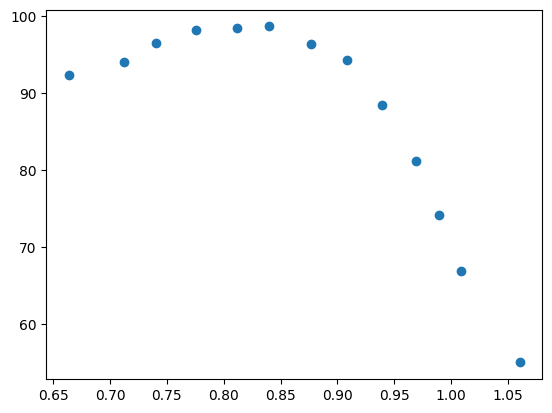

In [19]:
plt.scatter(sigma_arr, phi_lst)

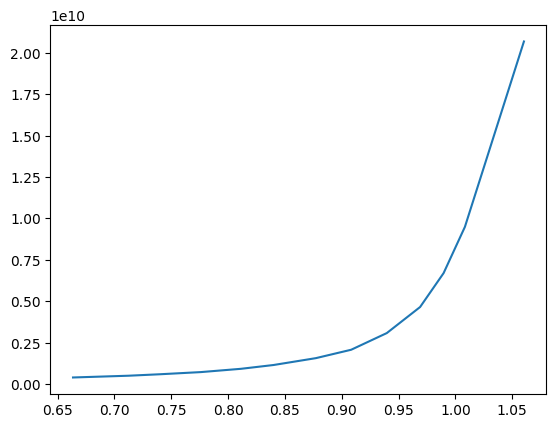

In [20]:
plt.plot(sigma_arr, energy_dct["absorbed_electrons"])

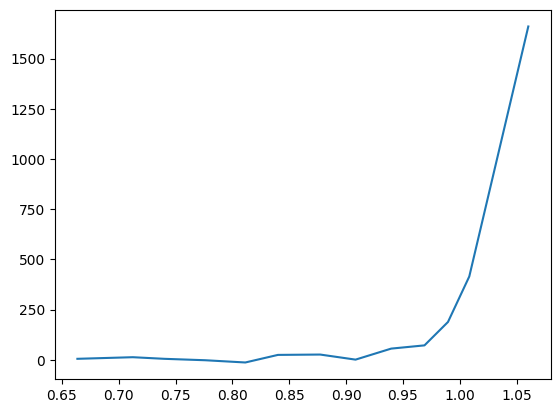

In [21]:
plt.plot(sigma_arr, impulse_dct["absorbed_electrons"])

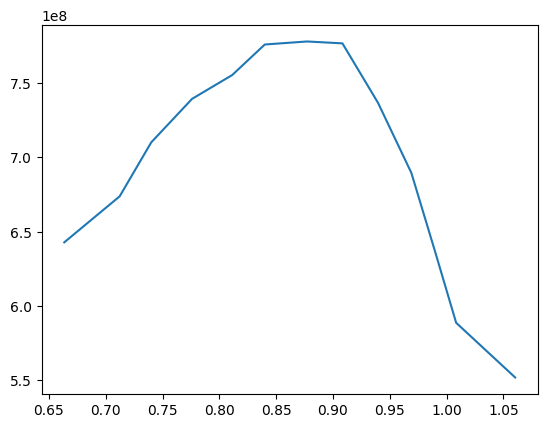

In [22]:
plt.plot(sigma_arr, energy_dct["absorbed_ions"])

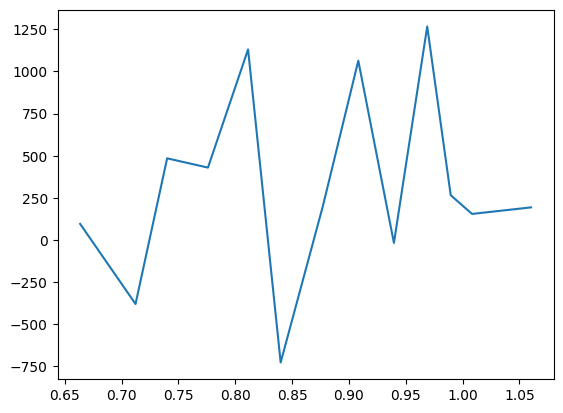

In [23]:
plt.plot(sigma_arr, impulse_dct["absorbed_ions"])

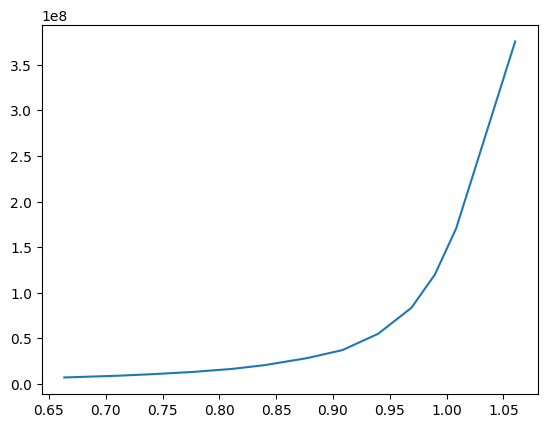

In [24]:
plt.plot(sigma_arr, energy_dct["secondary_electrons"])

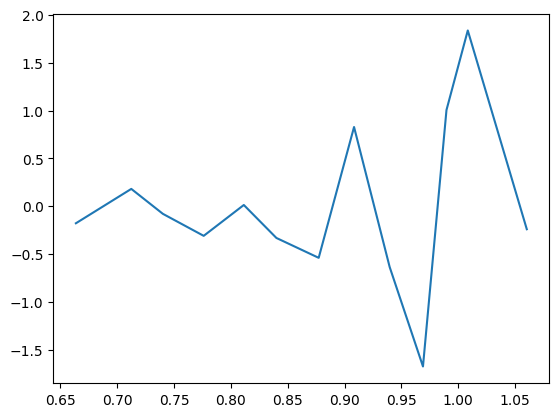

In [25]:
plt.plot(sigma_arr, impulse_dct["secondary_electrons"])